# Determine opt-out rate for desktop improvements feature on test wikis pt 2

[Task](https://phabricator.wikimedia.org/T269664)

## Purpose

We would like to know the percentage of logged-in users that have opted out from the new version of vector:
* per test wiki
* per user edit bucket


In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})

# QA of Desktop Improvements Schema

A new schema, [mediawiki_preff_diff](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/pref_diff/current.yaml), was created in [T261842](https://phabricator.wikimedia.org/T261842) to track the opt-ins and opt-outs of desktop improvements and deployed on 8 April 2021. Unlike PrefUpdate, this schema logs an arbitrary `intial` and `final` state (e.g. a user switched from latest Vector to Monobook). It also allows for the use of a hashed user ID. 

Schema  Documentation:
* https://gerrit.wikimedia.org/r/c/mediawiki/extensions/WikimediaEvents/+/668530
* https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/pref_diff/current.yaml


**QA Checks**:
I queried the data and looked through the following aggregations to determine if the data appears as expected based on instrumentation and time of deployment.
* Preference changes by date [PASS]
* Preference changes by wiki (all vs target wikis) [PASS]
* Preference changes by initial to final state [IN PRRoGRESS - ISSUES IDENTIFIED]
    * Updates to Vector and Modern skins vs updates to Vector 1 and 2. 
* Preference Changes by edit bucket [PASS]


In [2]:
query <- 
"
SELECT
    date_format(dt, 'yyyy-MM-dd') AS `date`,
    user_hash AS `user`,
    initial_state AS initial_state,
    final_state AS final_state,
    bucketed_user_edit_count AS edit_count,
    meta.domain as wiki,
    COUNT(*) AS num_selections
FROM event.mediawiki_pref_diff
WHERE 
    year = 2021
    AND month = 04
    AND day >= 15
GROUP BY
    date_format(dt, 'yyyy-MM-dd') ,
    user_hash,
    initial_state,
    final_state,
    bucketed_user_edit_count,
    meta.domain
"

In [3]:
desktop_pref_updates <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [5]:
desktop_pref_updates$date <- as.Date(desktop_pref_updates$date, format = "%Y-%m-%d")

In [125]:
options(repr.plot.width = 15, repr.plot.height = 15)

## Daily preference updates date across all wikis

In [126]:
desktop_pref_updates_events_bydate <- desktop_pref_updates %>%
    #filter(final_state %in% c('vector1', 'vector2')) %>%
    group_by(date) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))

desktop_pref_updates_events_bydate

`summarise()` ungrouping output (override with `.groups` argument)



date,total_selections,total_users
<date>,<int>,<int>
2021-04-15,57,35
2021-04-16,297,196
2021-04-17,257,171
2021-04-18,271,174
2021-04-19,360,230
2021-04-20,300,197
2021-04-21,294,193
2021-04-22,270,177
2021-04-23,232,156


Events start appearing in the database on April 15th. There is an average 260 preference updates by 171 users per day. This is expected as it's possible for the same user to make more than one preference update.

`summarise()` regrouping output by 'date' (override with `.groups` argument)



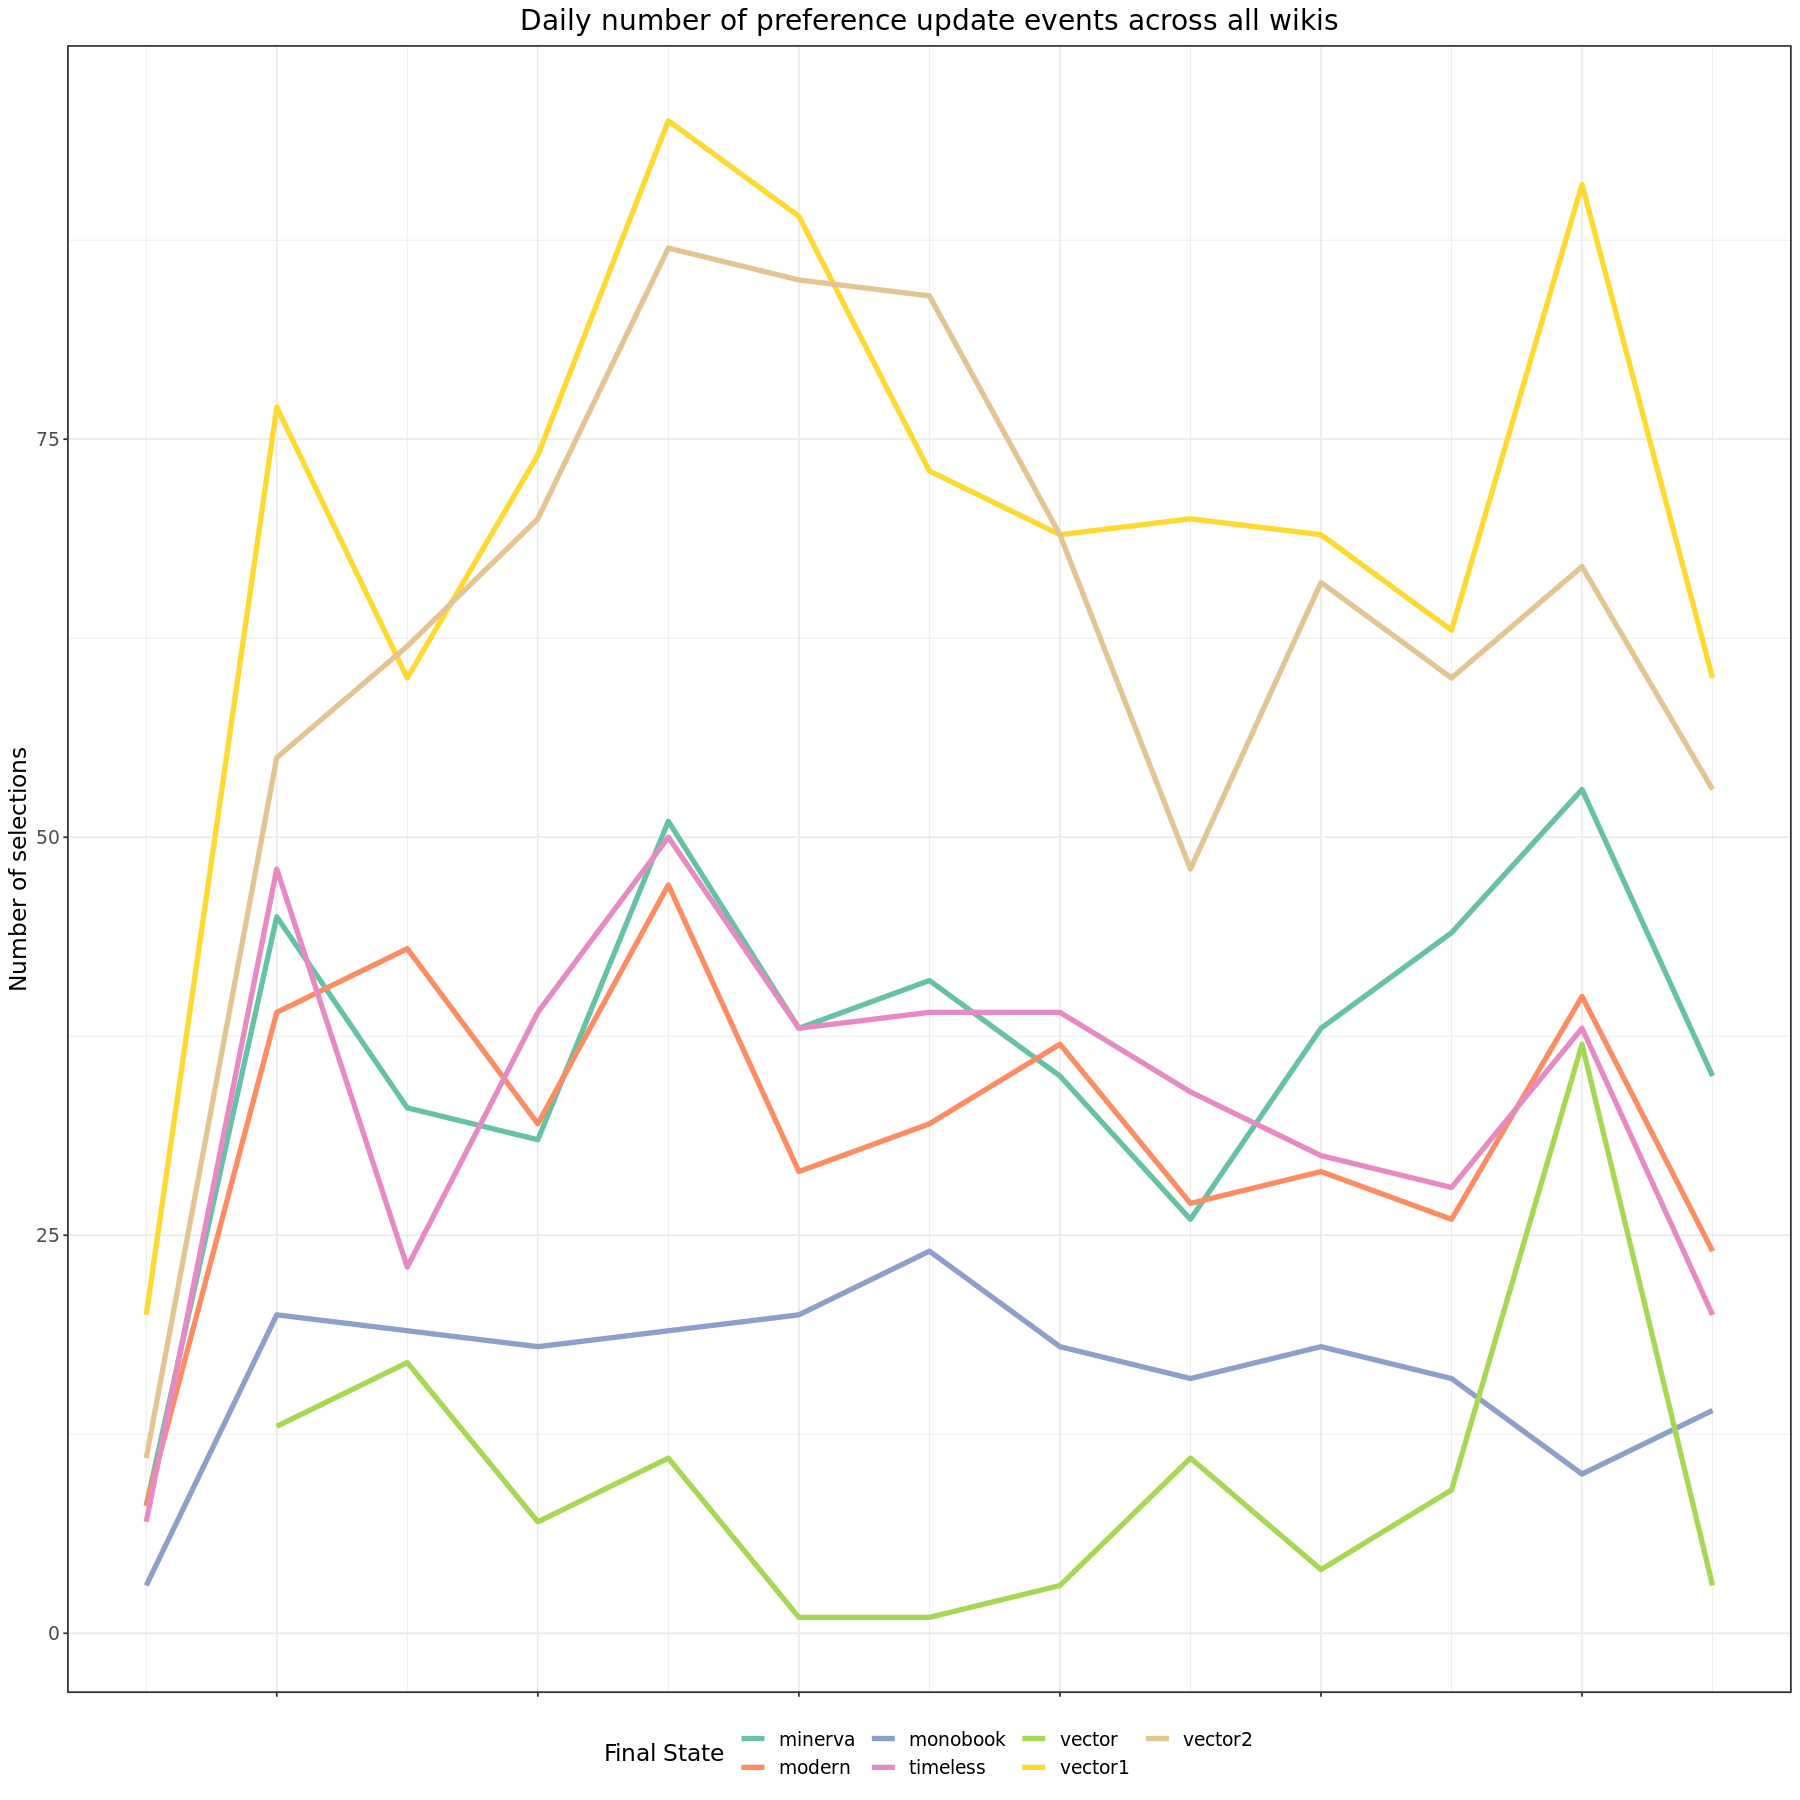

In [131]:
p <- desktop_pref_updates %>%
    #filter(final_state %in% c('vector1', 'vector2')) %>%
    group_by(date, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) %>%
    ggplot(aes(x = date, y = total_selections, color = final_state)) +
       geom_line(size = 1.5) +
       labs(title = "Daily number of preference update events across all wikis",
           y = "Number of selections") +
        theme_bw() +
        scale_color_brewer(name="Final State", palette="Set2")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")

p

`summarise()` regrouping output by 'date' (override with `.groups` argument)



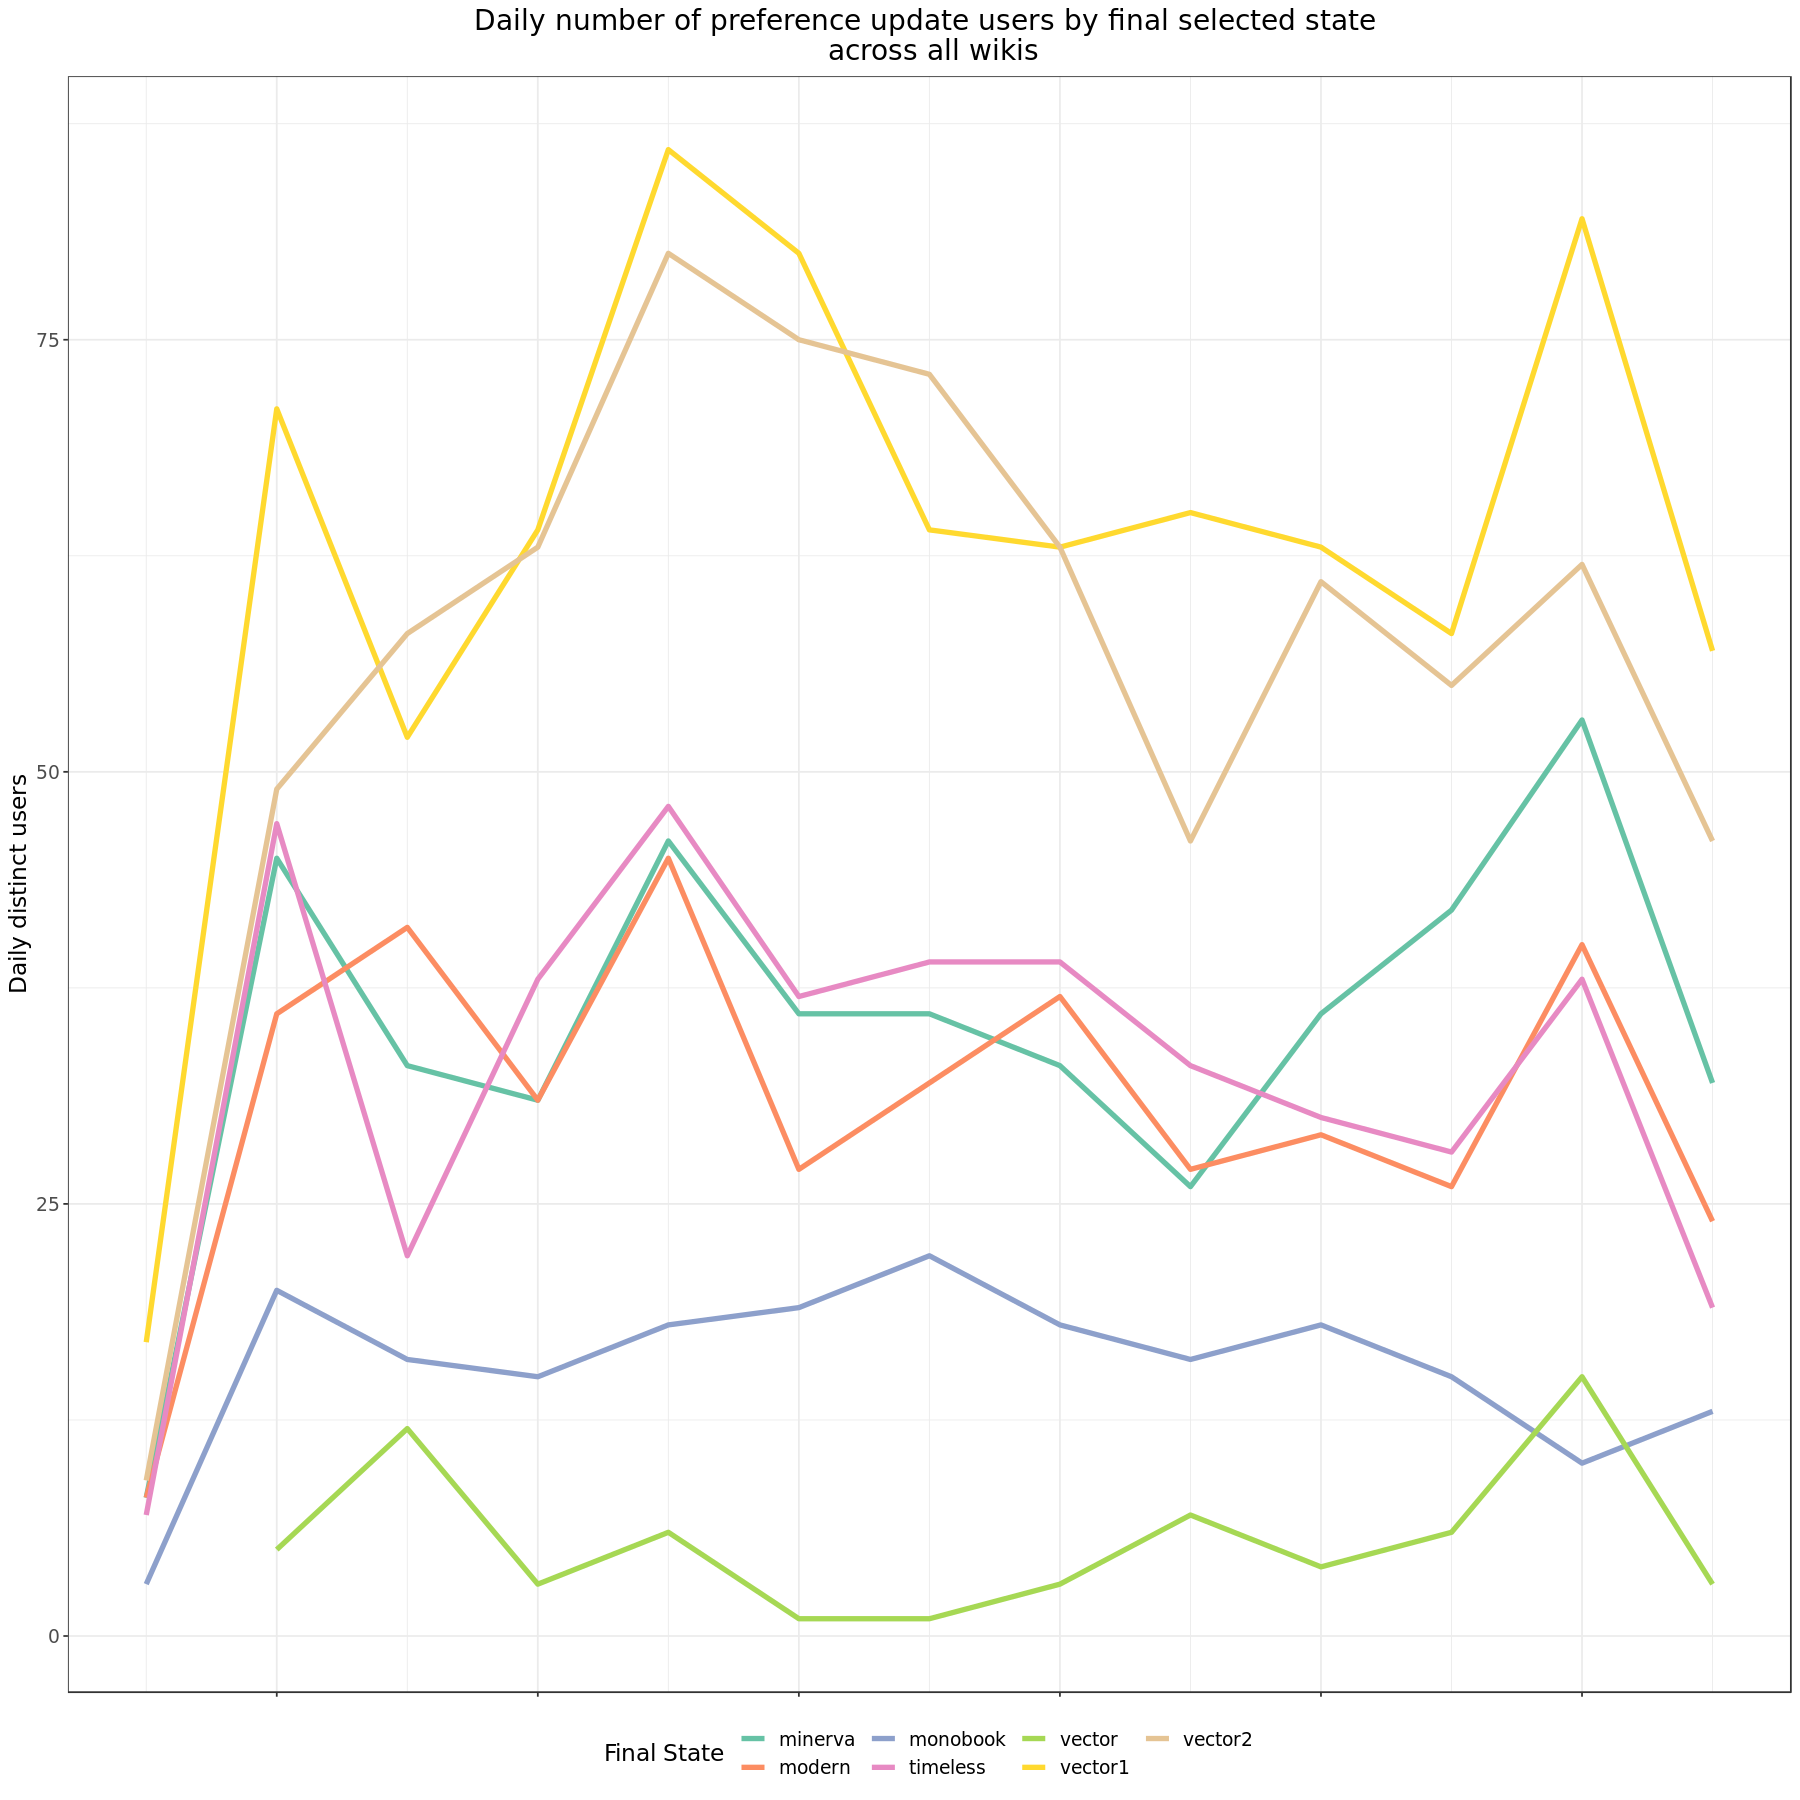

In [134]:
p <- desktop_pref_updates %>%
    #filter(final_state %in% c('vector1', 'vector2')) %>%
    group_by(date, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))  %>%
    ggplot(aes(x = date, y = total_users, color = final_state)) +
       geom_line(size = 1.5) +
       labs(title = "Daily number of preference update users by final selected state \n across all wikis",
           y = "Daily distinct users")+
        theme_bw() +
        scale_color_brewer(name="Final State", palette="Set2")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")

p

A review of the daily number of final state preference updates by user and wiki appear as expected. The majority of preference updates each day since we began recording are for vector 1 and vector2 desktop skins. Daily trends are consistent - There are no signficant drops or spikes in the data indicating any anomalies. 


## Daily preference updates on target wikis by Vector Version

In [56]:
desktop_pref_updates_events_bydate_target <- desktop_pref_updates %>%
    filter(wiki %in% c('fr.wiktionary.org', 'he.wikipedia.org', 'pt.wikiversity.org', 'fr.wikipedia.org', 
    'eu.wikipedia.org', 'fa.wikipedia.org', 'pt.wikipedia.org', 'ko.wikipedia.org', 'tr.wikipedia.org', 
                       'sr.wikipedia.org', 'bn.wikipedia.org', 'de.wikivoyage.org', 'vec.wikipedia.org'))  %>%
    filter(final_state %in% c('vector1', 'vector2'),
          initial_state %in% c('vector1', 'vector2')) %>%
    group_by(date, wiki, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))



`summarise()` regrouping output by 'date', 'wiki' (override with `.groups` argument)



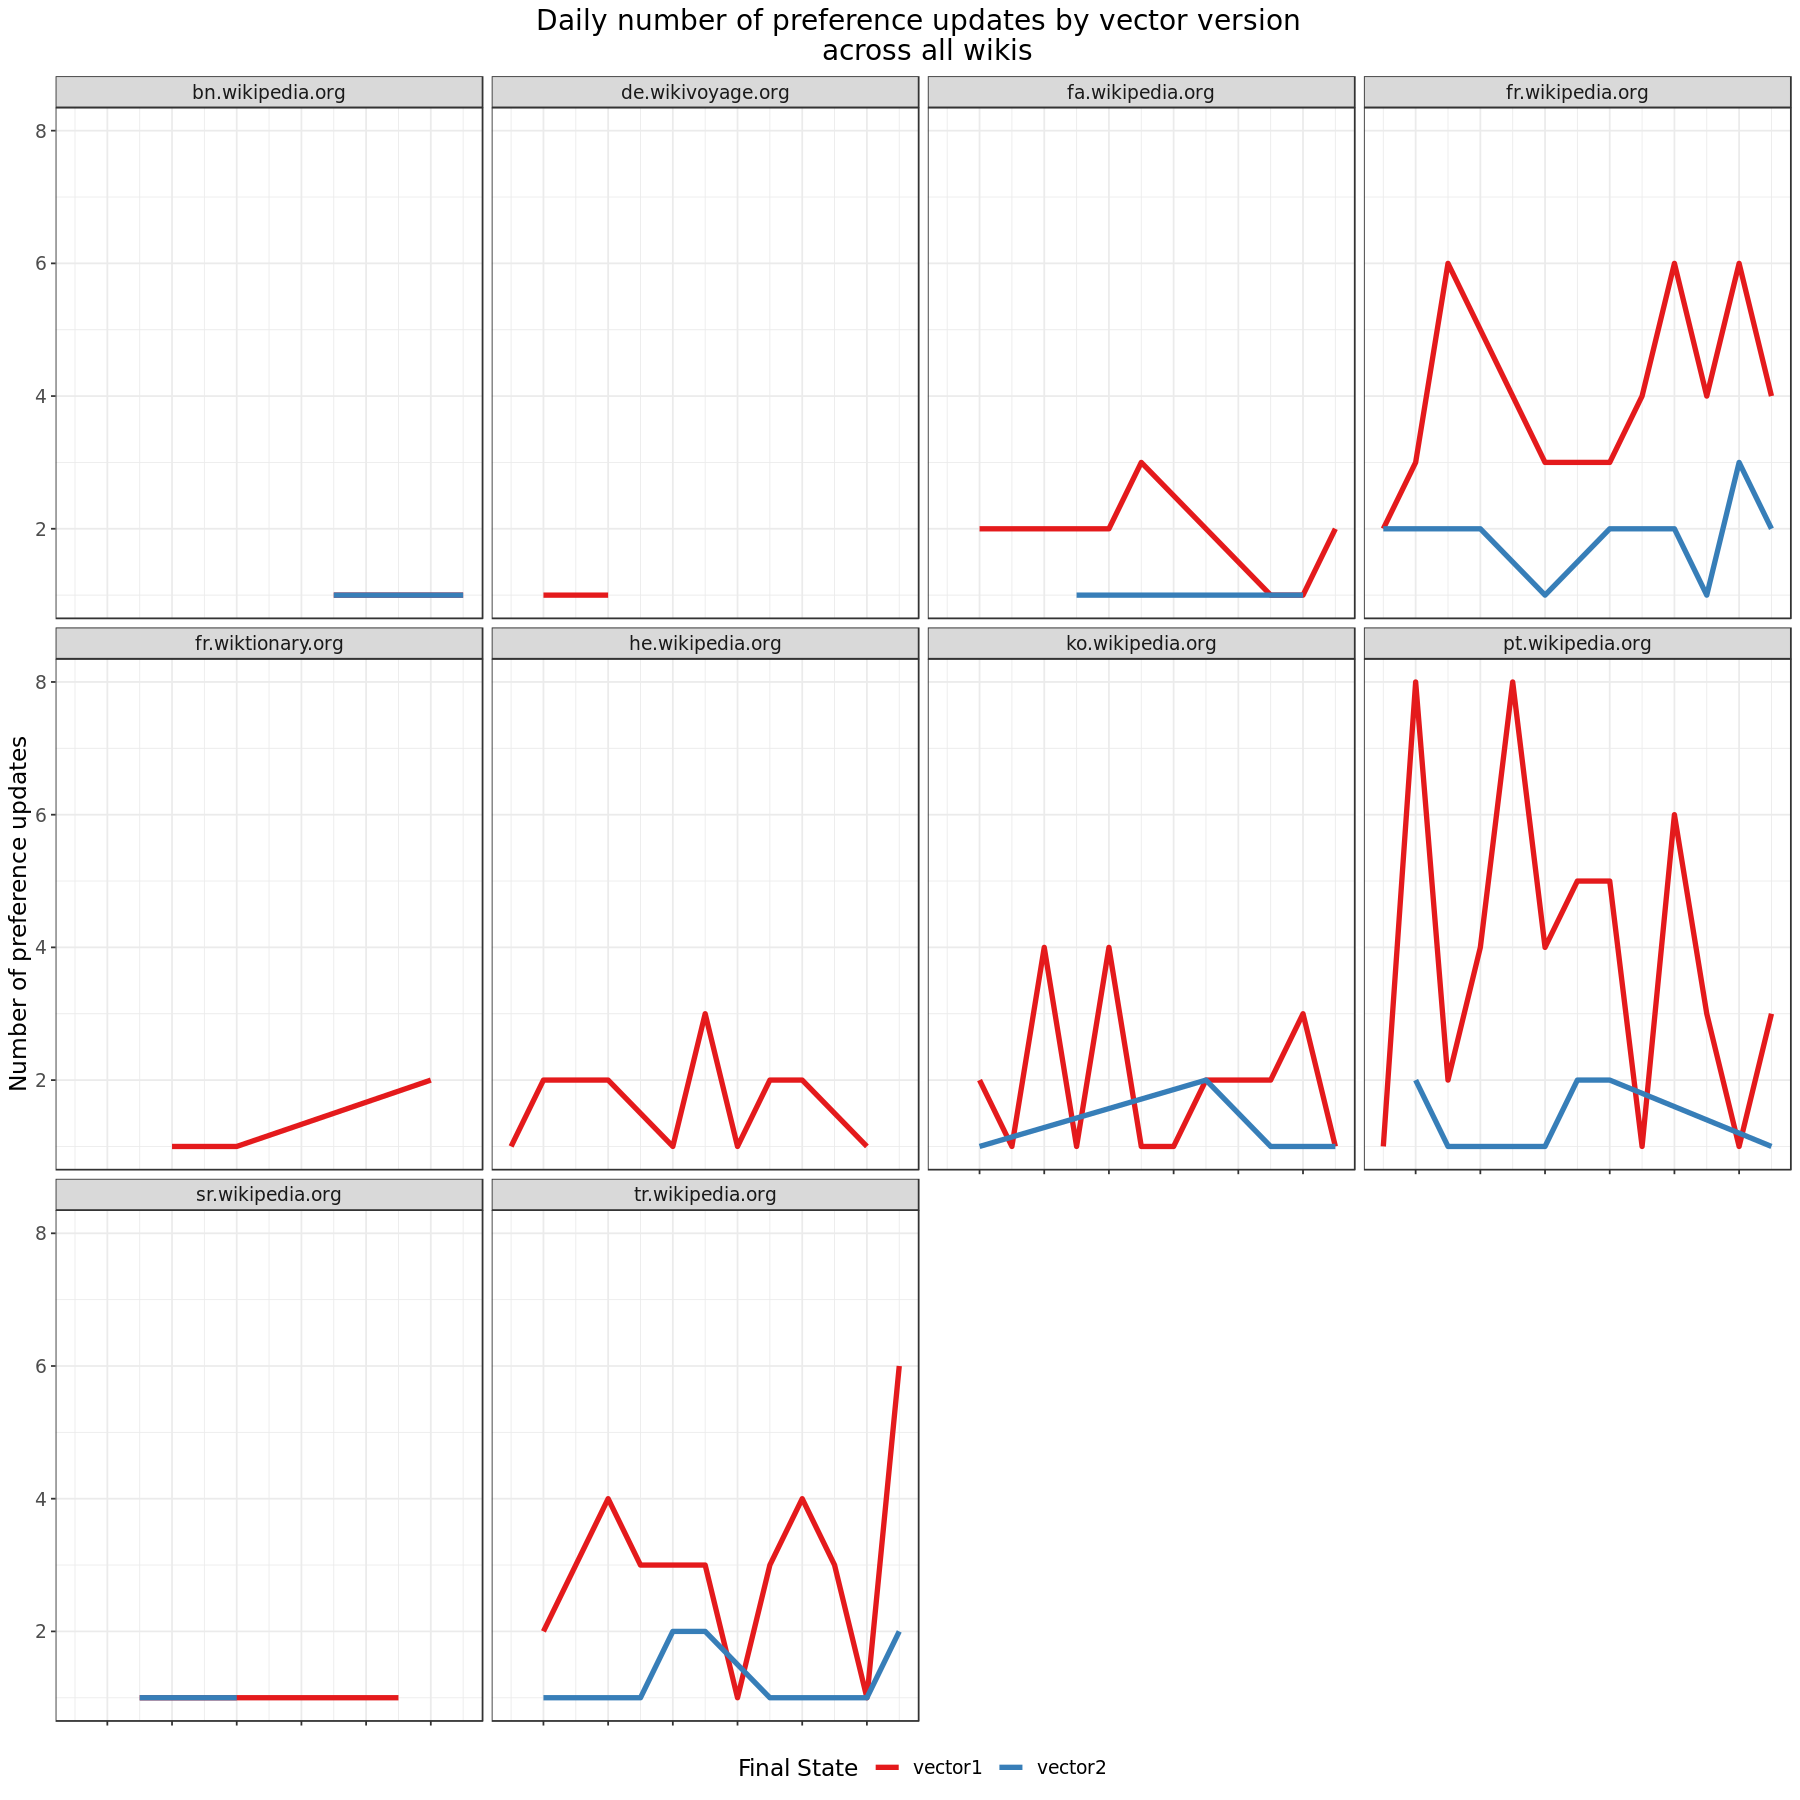

In [140]:
p <- desktop_pref_updates_events_bydate_target %>%
    ggplot(aes(x = date, y = total_selections, color = final_state)) +
       geom_line(size = 1.5) +
        facet_wrap (~ wiki) +
       labs(title = "Daily number of preference updates by vector version \n across all wikis",
           y = "Number of preference updates")  +
        scale_color_brewer(name="Final State", palette="Set1")  +
        theme_bw() +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")

p

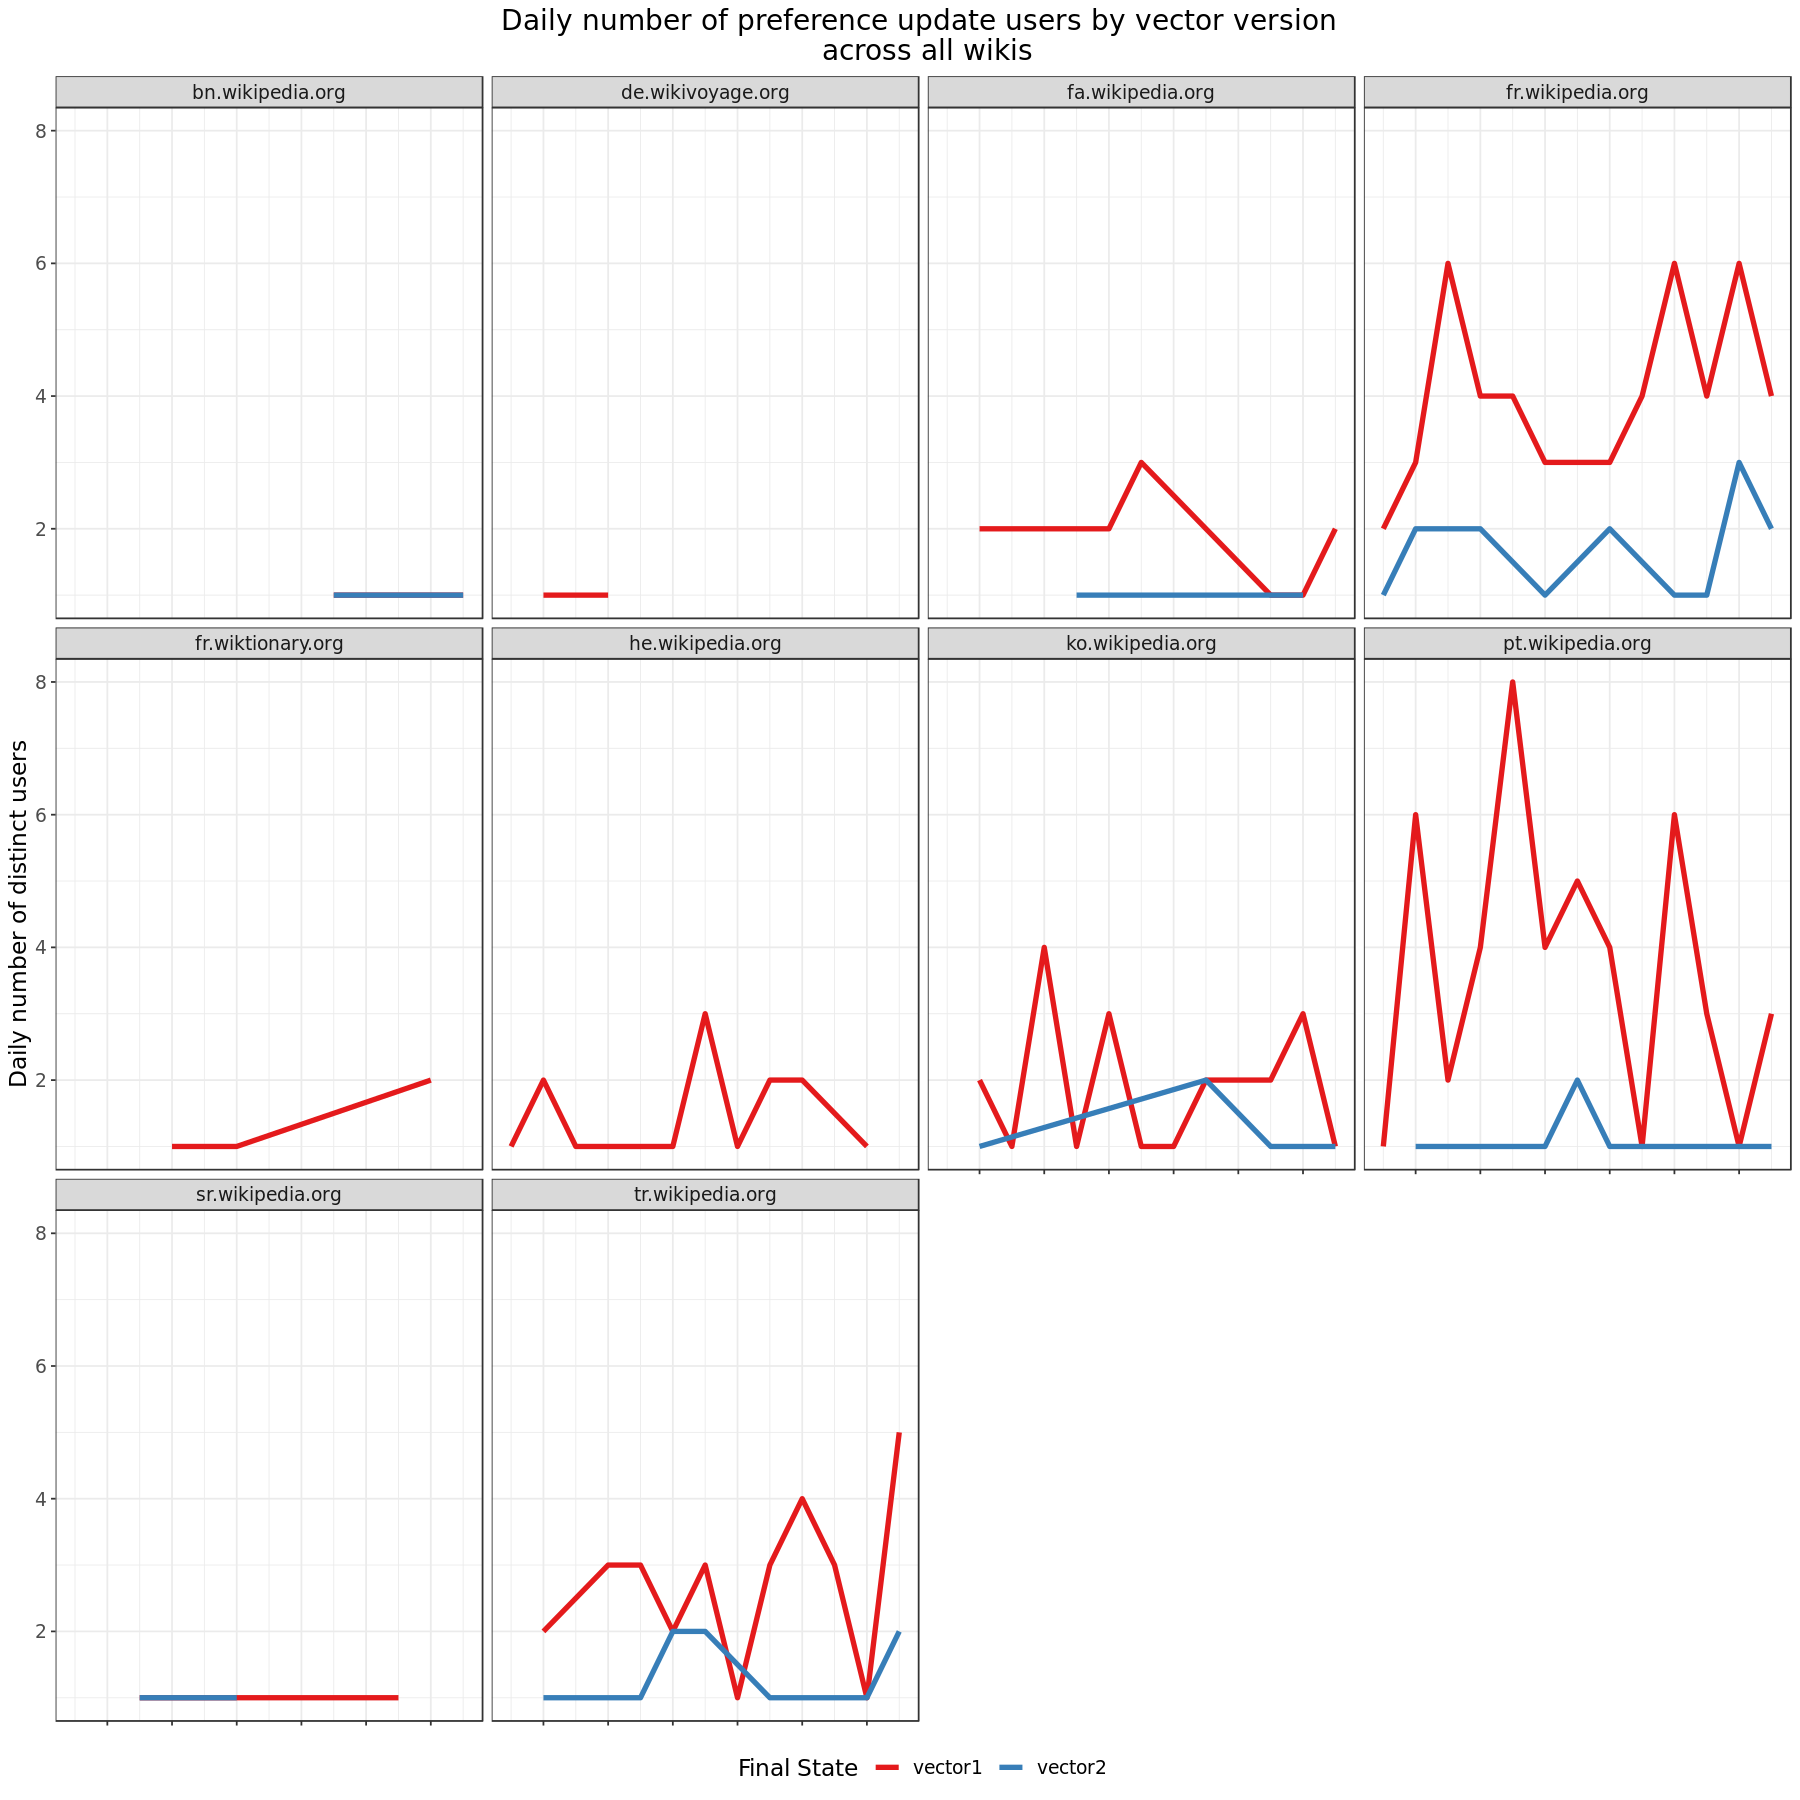

In [139]:
p <- desktop_pref_updates_events_bydate_target %>%
    ggplot(aes(x = date, y = total_users, color = final_state)) +
       geom_line(size = 1.5) +
        facet_wrap (~ wiki) +
       labs(title = "Daily number of preference update users by vector version \n across all wikis",
           y = "Daily number of distinct users")  +
        scale_color_brewer(name="Final State", palette="Set1")  +
        theme_bw() +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")

p


There are more users that opt-out than opt-in as this new desktop skin (vector2) was presented as default to all logged-in users on all target wikis.

There have only been 1 to 8 vector opt-in or opt-outs a day on each target wiki since April 15th

# Initial and Final State Selection Totals 

# For all Wikis

In [83]:
desktop_pref_updates_bystate <- desktop_pref_updates %>%
    group_by(initial_state, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))

desktop_pref_updates_bystate

`summarise()` regrouping output by 'initial_state' (override with `.groups` argument)



initial_state,final_state,total_selections,total_users
<chr>,<chr>,<int>,<int>
cologneblue,vector1,3,3
cologneblue,vector2,3,3
minerva,vector1,149,139
minerva,vector2,101,95
modern,vector1,90,89
modern,vector2,77,65
monobook,vector1,100,83
monobook,vector2,66,65
timeless,vector1,136,133


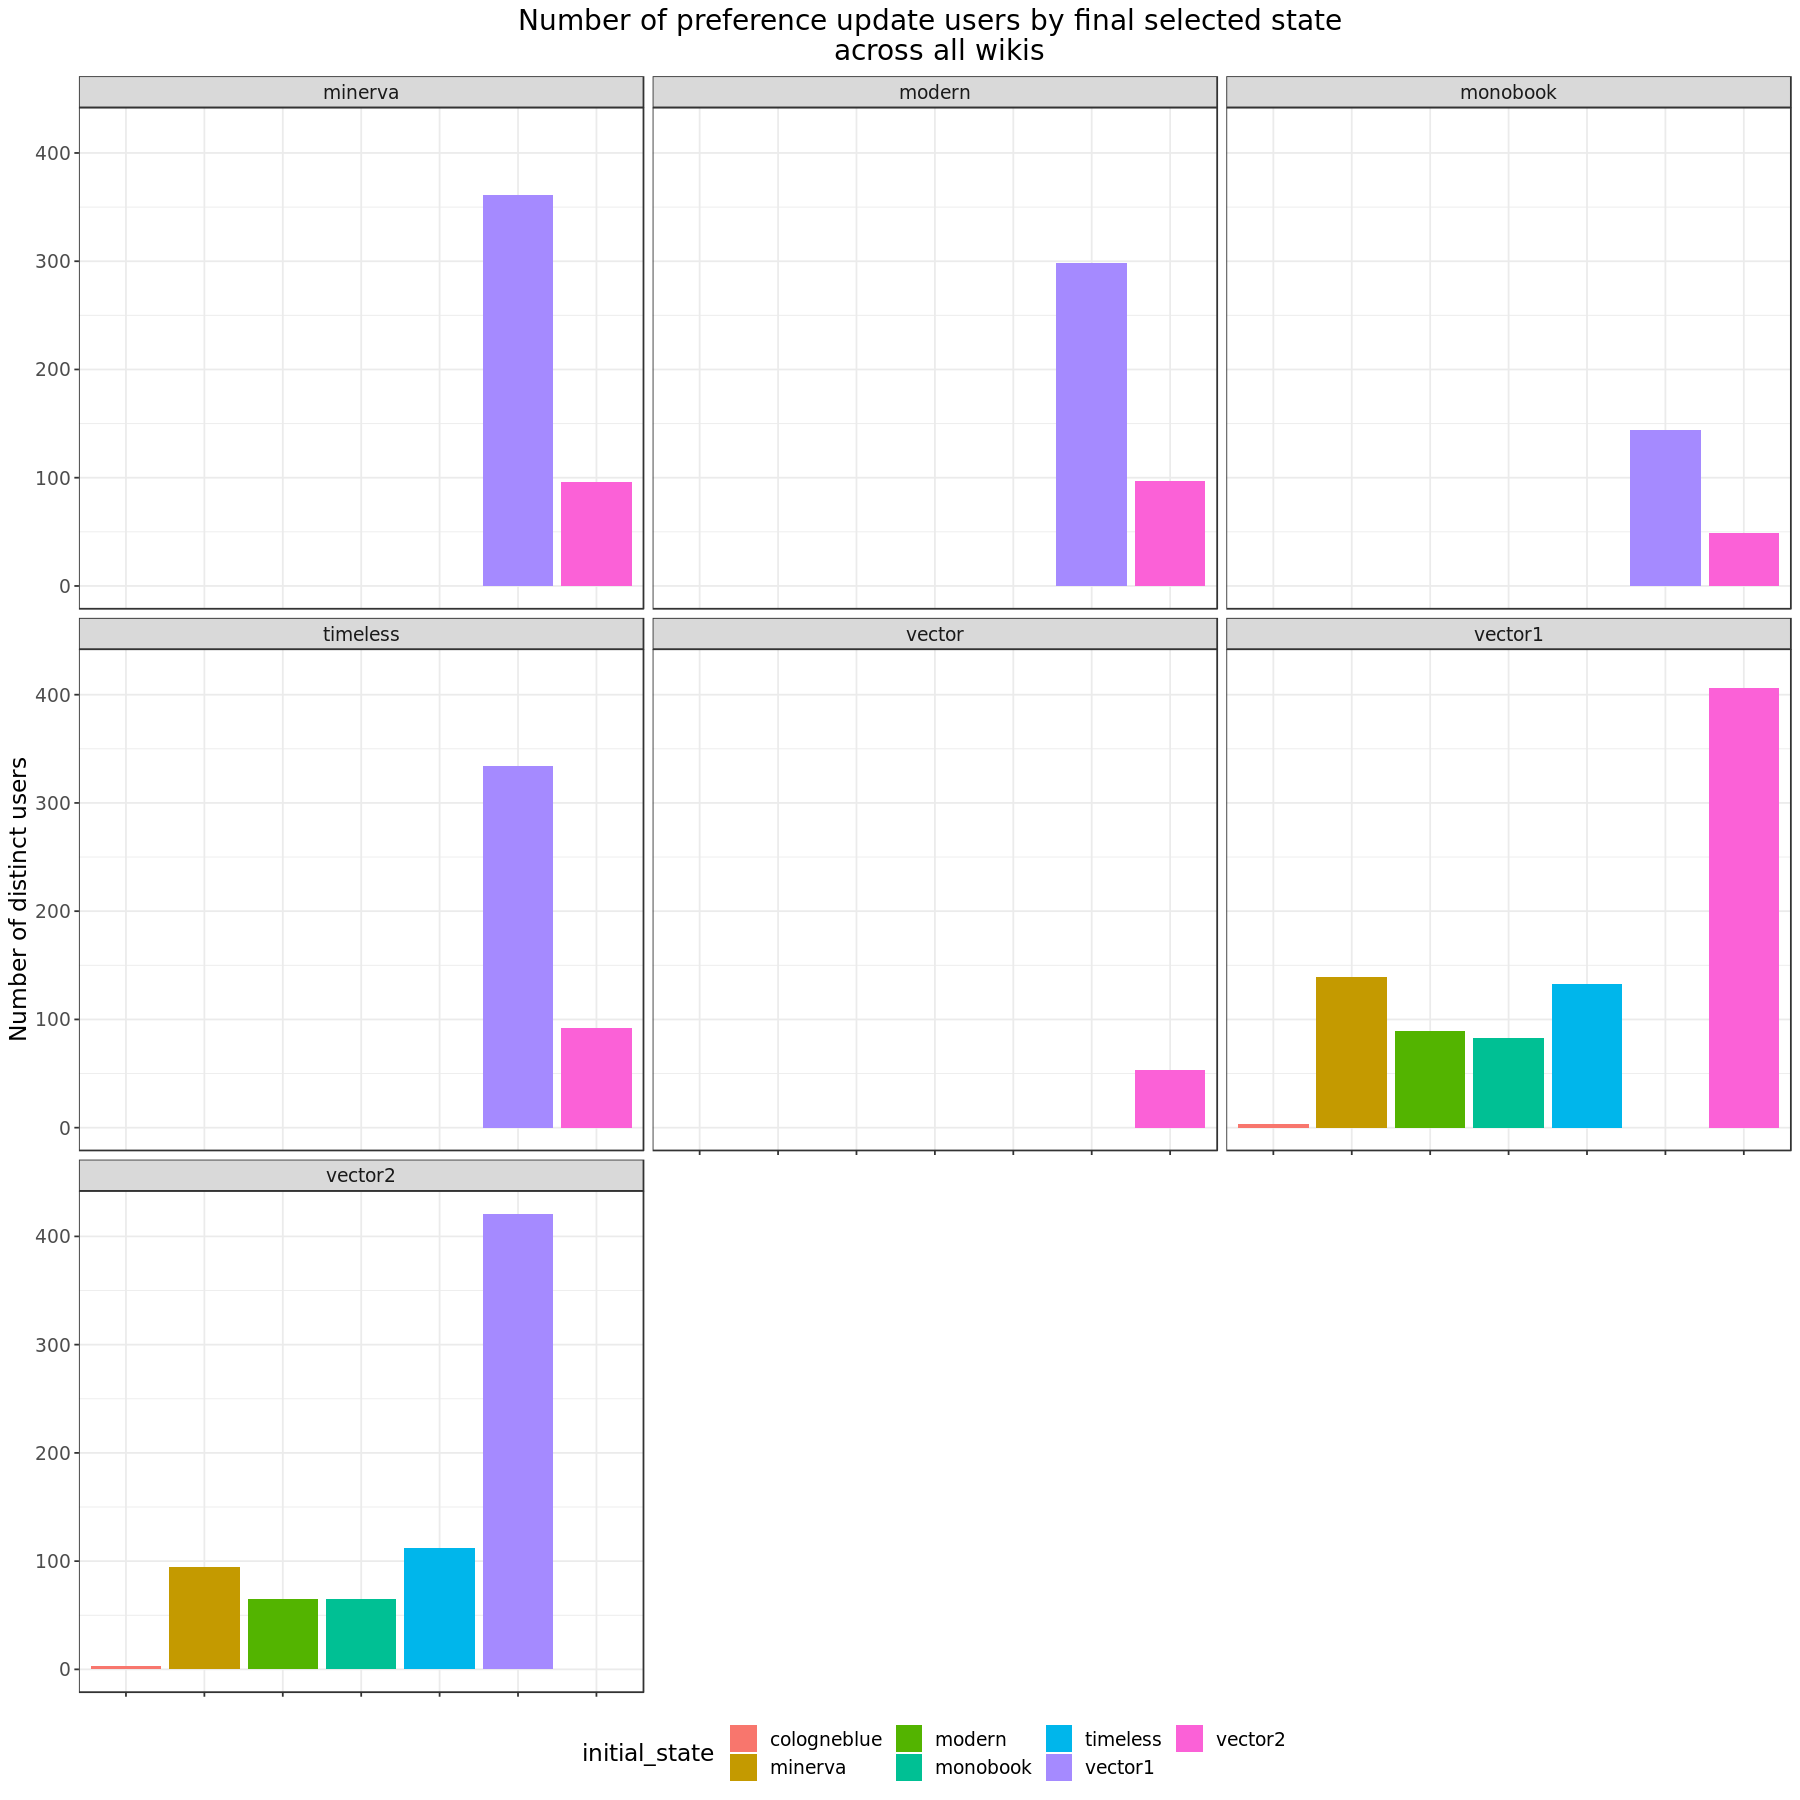

In [149]:
p <- desktop_pref_updates_bystate %>%
    ggplot(aes(x= initial_state, y = total_users, fill = initial_state)) +
       geom_col() +
        facet_wrap(~ final_state) +
       labs(title = "Number of preference update users by final selected state \n across all wikis",
           y = "Number of distinct users")  +
        theme_bw() +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")

p
    


Potential Issues: We're recording a couple instances of someone going from vector 2 to vector (instead of vector 1). Not sure what these instances indicate?

## For Target Wikis

In [153]:
desktop_pref_updates_bystate_target <- desktop_pref_updates %>%
    filter(wiki %in% c('fr.wiktionary.org', 'he.wikipedia.org', 'pt.wikiversity.org', 'fr.wikipedia.org', 
    'eu.wikipedia.org', 'fa.wikipedia.org', 'pt.wikipedia.org', 'ko.wikipedia.org', 'tr.wikipedia.org', 
                       'sr.wikipedia.org', 'bn.wikipedia.org', 'de.wikivoyage.org', 'vec.wikipedia.org'))  %>%
    group_by(initial_state, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))

desktop_pref_updates_bystate_target

`summarise()` regrouping output by 'initial_state' (override with `.groups` argument)



initial_state,final_state,total_selections,total_users
<chr>,<chr>,<int>,<int>
minerva,vector1,10,10
minerva,vector2,31,31
modern,vector1,7,7
modern,vector2,27,26
monobook,vector1,6,6
monobook,vector2,18,18
timeless,vector1,14,14
timeless,vector2,40,38
vector1,minerva,15,15


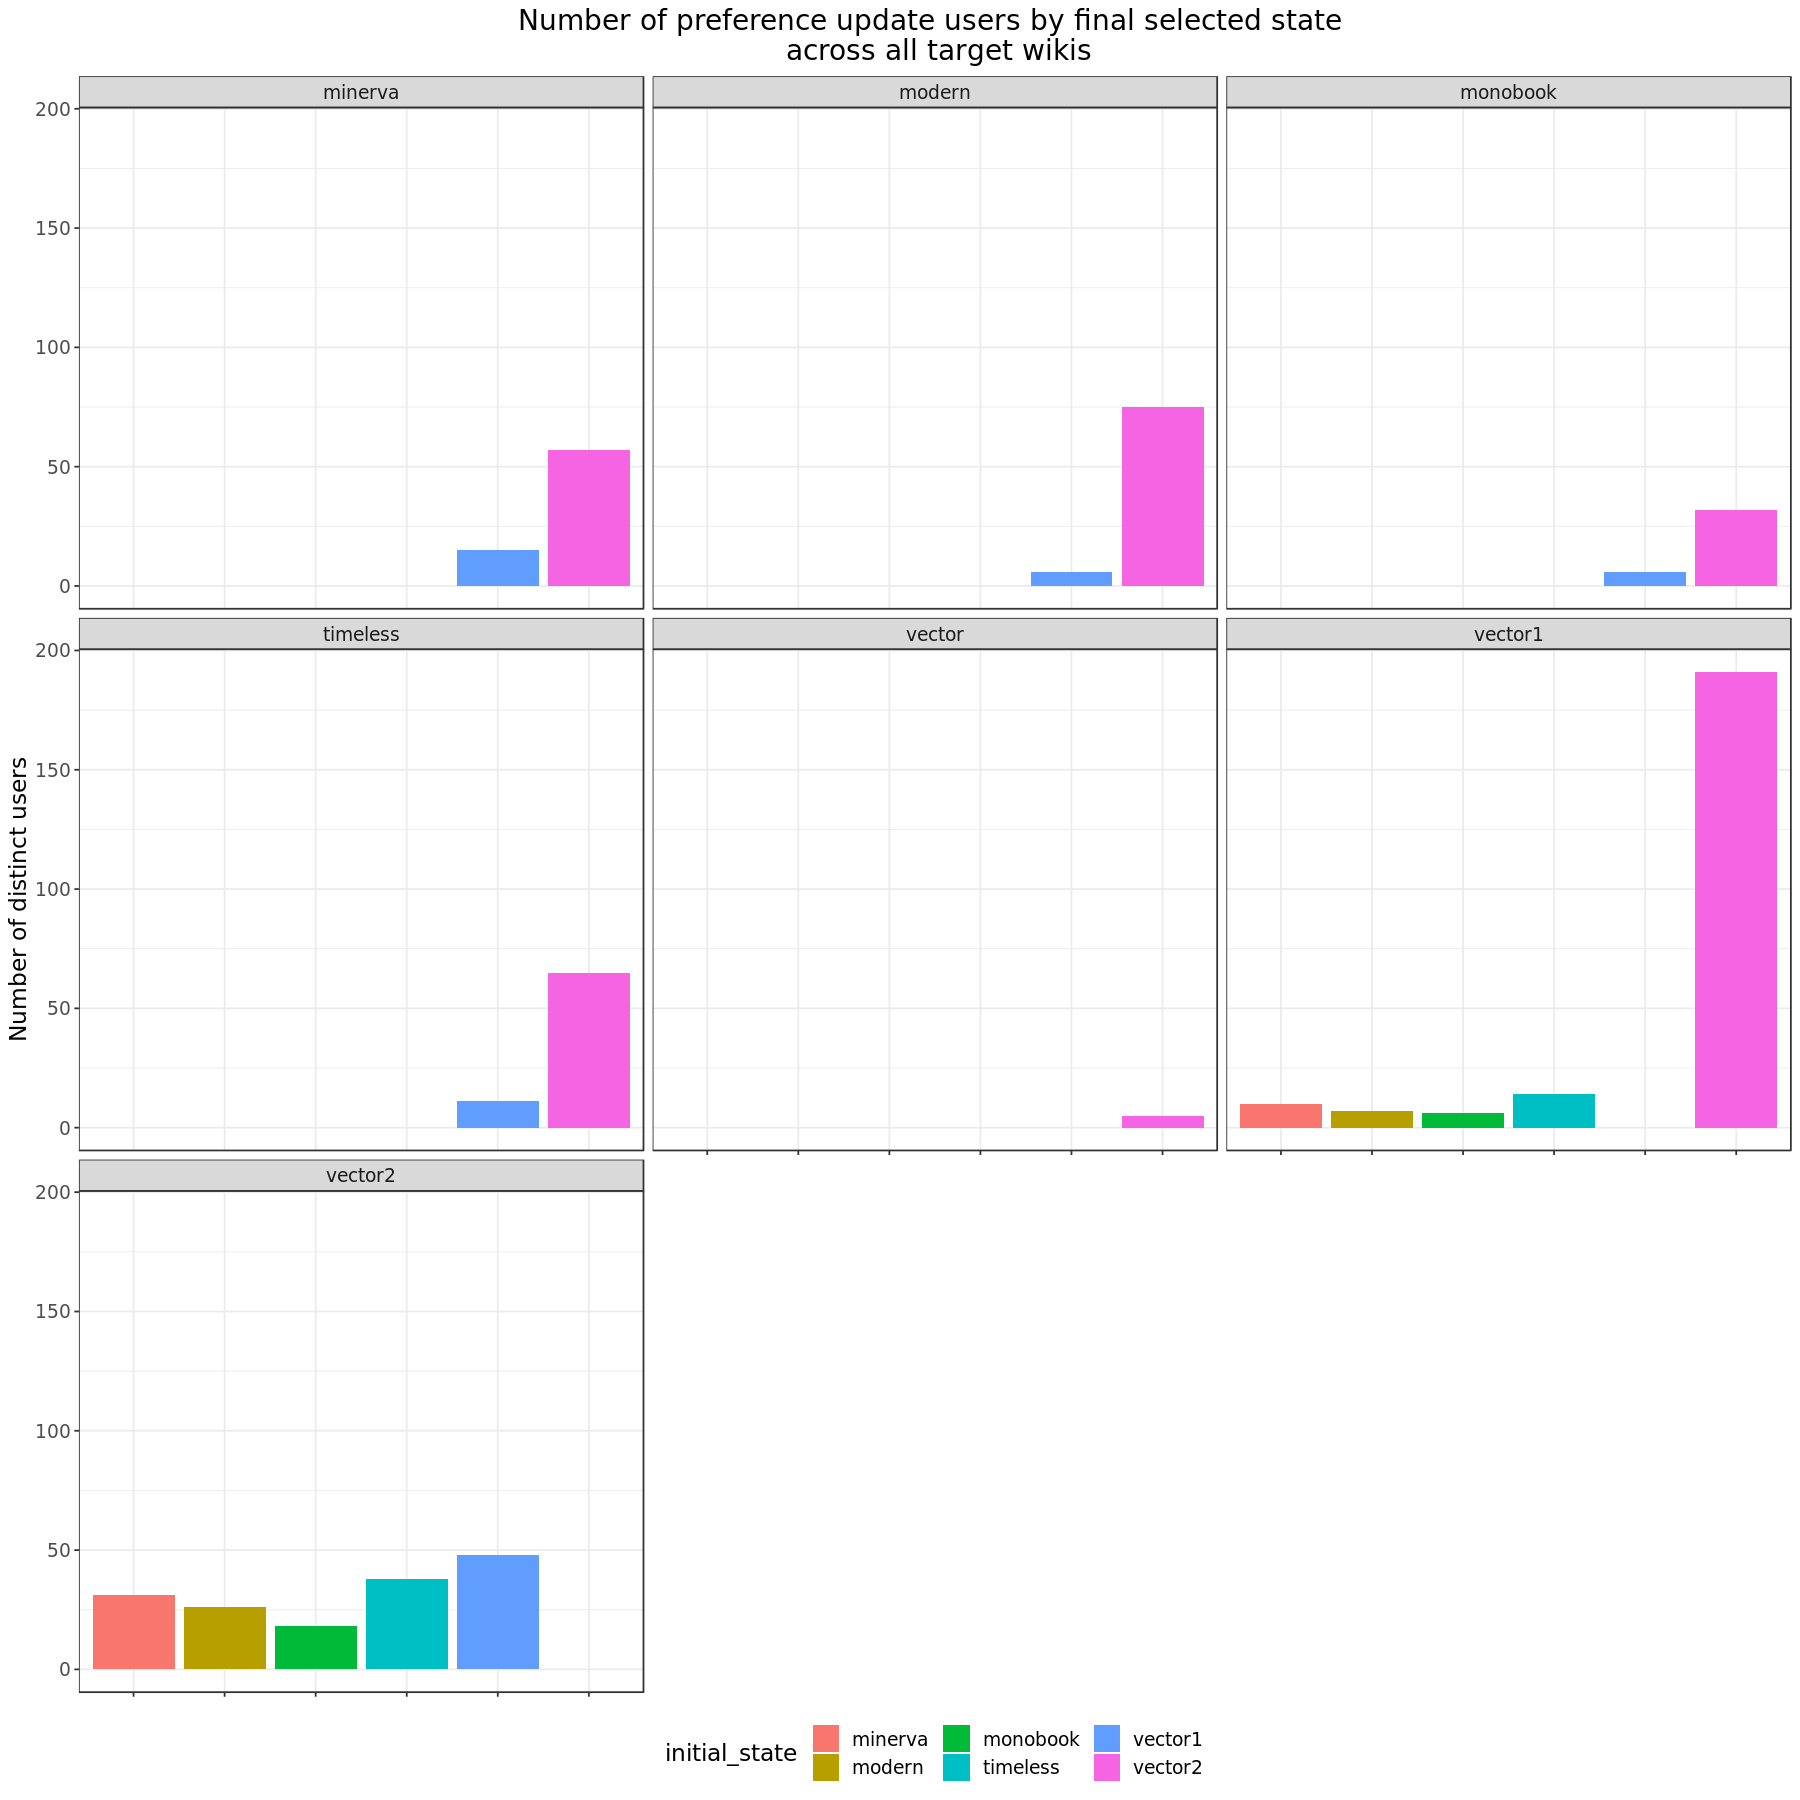

In [154]:
p <- desktop_pref_updates_bystate_target %>%
    ggplot(aes(x= initial_state, y = total_users, fill = initial_state)) +
       geom_col() +
        facet_wrap(~ final_state) +
       labs(title = "Number of preference update users by final selected state \n across all target wikis",
           y = "Number of distinct users") + 
        theme_bw() +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")


p

The number of updates to each available desktop skin appears to fit with current config states. For the target wikis, the majority of users updated their preferences from vector2 to vector1, which is expected since vector 2 was deployed as opt-out to all of the pilot wikis. Users would only need to explicility update their preference to Vector2 from Vector1 if they opt-out and then decided to opt back in again. 

We see more users update from vector 1 to vector 2 when looking across all wikis since it is available as an opt-in preference across all wikis. 

We still see a few switches from vector 2 to just vector.  I reviewed these instances furhter to see if I could isolate to a wiki or date. 


## Vector 2 to Vector Switches

In [98]:
vec2_to_vector <- desktop_pref_updates %>%
    filter(initial_state == 'vector2',
          final_state == 'vector') %>%
    group_by( wiki) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) 


vec2_to_vector

`summarise()` ungrouping output (override with `.groups` argument)



wiki,total_selections,total_users
<chr>,<int>,<int>
bn.wikipedia.org,1,1
bn.wikisource.org,1,1
bn.wikivoyage.org,1,1
bs.wikipedia.org,4,2
commons.wikimedia.org,4,3
de.wikipedia.org,3,1
en.wikinews.org,2,1
en.wikipedia.org,35,14
en.wikisource.org,4,1


The vector2 to vector switch across a number of different wiki projects including test and non-test wikis so there doesn't seem to be a correlation there.

In [156]:
vec2_to_vector_daily <- desktop_pref_updates %>%
    filter(initial_state == 'vector2',
          final_state == 'vector') %>%
    group_by(date, wiki) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) 
vec2_to_vector_daily

`summarise()` regrouping output by 'date' (override with `.groups` argument)



date,wiki,total_selections,total_users
<date>,<chr>,<int>,<int>
2021-04-16,commons.wikimedia.org,1,1
2021-04-16,en.wikipedia.org,3,1
2021-04-16,en.wiktionary.org,1,1
2021-04-16,fr.wikipedia.org,7,1
2021-04-16,zh.wikipedia.org,1,1
2021-04-17,commons.wikimedia.org,1,1
2021-04-17,en.wikinews.org,2,1
2021-04-17,en.wikipedia.org,8,4
2021-04-17,en.wikisource.org,1,1


No sharp increases or declines by date or wiki. Most of these switches from 'vector2' to 'vector' occur on en.wikpedia or zh.wikipedia.

# By User Edit Bucket

In [122]:
# set factor levels
desktop_pref_updates$edit_count <- factor(desktop_pref_updates$edit_count, levels = c("0 edits", "1-4 edits",
                                                                                     "5-99 edits", "100-999 edits",
                                                                                     "1000+ edits"))

## Across all wikis

In [123]:
desktop_pref_updates_usercount <- desktop_pref_updates %>%
    group_by(edit_count) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))

desktop_pref_updates_usercount

`summarise()` ungrouping output (override with `.groups` argument)



edit_count,total_selections,total_users
<fct>,<int>,<int>
0 edits,1425,1012
1-4 edits,488,324
5-99 edits,715,421
100-999 edits,318,158
1000+ edits,437,192


The data by edit count appears as expected. We see the most preference switches by users with 0 edits. Almost half of all the preference updates come from users with 0 edits (48.03%). For editors (those that have made at least 1 edit), the majority of desktop preference updates (68%) are by users with under 99 edits.

## Target Wikis Only (Isolated to Only Vector Version Switches)

In [124]:
desktop_pref_updates_usercount_target <- desktop_pref_updates %>%
    filter(wiki %in% c('fr.wiktionary.org', 'he.wikipedia.org', 'pt.wikiversity.org', 'fr.wikipedia.org', 
    'eu.wikipedia.org', 'fa.wikipedia.org', 'pt.wikipedia.org', 'ko.wikipedia.org', 'tr.wikipedia.org', 
                       'sr.wikipedia.org', 'bn.wikipedia.org', 'de.wikivoyage.org', 'vec.wikipedia.org')) %>%
    filter(final_state %in% c('vector1', 'vector2'),
          initial_state %in% c('vector1', 'vector2')) %>%
    group_by(edit_count, final_state) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))

desktop_pref_updates_usercount_target 

`summarise()` regrouping output by 'edit_count' (override with `.groups` argument)



edit_count,final_state,total_selections,total_users
<fct>,<chr>,<int>,<int>
0 edits,vector1,71,68
0 edits,vector2,9,8
1-4 edits,vector1,29,29
1-4 edits,vector2,2,2
5-99 edits,vector1,46,42
5-99 edits,vector2,13,11
100-999 edits,vector1,25,23
100-999 edits,vector2,10,10
1000+ edits,vector1,34,30
